## Setup enviroment and load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!rm -r /content/sample_data

Mounted at /content/drive


In [ ]:
!pip install stellargraph[demos]
!pip install tensorflow_addons
!pip install imbalanced-learn

In [ ]:
# https://drive.google.com/file/d/1Kn1LGPCPugrCuw5zog0waegrqpGMcB0c/view?usp=sharing
# https://drive.google.com/file/d/1GqIBefMIC3C00rtBXWBoc0EDjdbckr0d/view?usp=sharing
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Kn1LGPCPugrCuw5zog0waegrqpGMcB0c' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Kn1LGPCPugrCuw5zog0waegrqpGMcB0c" -O "data.zip" && rm -rf /tmp/cookies.txt


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GqIBefMIC3C00rtBXWBoc0EDjdbckr0d' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GqIBefMIC3C00rtBXWBoc0EDjdbckr0d" -O "data.zip" && rm -rf /tmp/cookies.txt

--2022-04-25 02:43:19--  https://docs.google.com/uc?export=download&confirm=t&id=1GqIBefMIC3C00rtBXWBoc0EDjdbckr0d
Resolving docs.google.com (docs.google.com)... 74.125.24.138, 74.125.24.100, 74.125.24.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.24.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hall10jvavdmnt2hkgj4pcb21j1k9bsq/1650854550000/05739447287618408964/*/1GqIBefMIC3C00rtBXWBoc0EDjdbckr0d?e=download [following]
--2022-04-25 02:43:20--  https://doc-08-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hall10jvavdmnt2hkgj4pcb21j1k9bsq/1650854550000/05739447287618408964/*/1GqIBefMIC3C00rtBXWBoc0EDjdbckr0d?e=download
Resolving doc-08-4o-docs.googleusercontent.com (doc-08-4o-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to doc-08-4o-docs.googleusercontent.com (doc-08-4o-docs

In [ ]:
!unzip "/content/data.zip"
!rm "/content/data.zip"

Archive:  /content/data.zip
  inflating: X_test.npy              
  inflating: X_train.npy             
  inflating: y_test.npy              
  inflating: y_train.npy             


In [ ]:
import pickle

X_test = pickle.load(open("X_test.npy", "rb"))
y_test = pickle.load(open("y_test.npy", "rb"))
X_train = pickle.load(open("X_train.npy", "rb"))
y_train = pickle.load(open("y_train.npy", "rb"))

In [ ]:
import pandas as pd
import numpy as np
import stellargraph as sg
import cv2
from tensorflow.keras.callbacks import EarlyStopping

n_node_feature = 69+64+1
n_node_max = 112
np.random.seed(10)
n_class = 1
# n_edge_type = 13
n_edge_type = 2 + n_node_feature + 13

In [ ]:
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

## Representation learning with 1 epoch

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling1D,Input,concatenate,Concatenate
from stellargraph.layer.gcn import GraphConvolution
import tensorflow_addons as tfa

# Model CNN cũ
# Sửa lại padding = same cho tất cả các Conv layer
# Thêm 1 block Conv
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(n_node_max,n_node_max, 1)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    
    return model

def create_gcn_model():
    x_features = Input(shape=( n_node_max, n_node_feature))
    x_adjacency = Input(shape=( n_node_max, n_node_max))
    out = Dropout(0.5)(x_features)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])
    out = Dropout(0.5)(out)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])

    # out = GlobalAveragePooling1D()(out)
    out = Flatten()(out)
    out = Dense(64, activation='relu')(out)
    out = Dropout(.25)(out)

    model = Model(inputs=[x_features, x_adjacency], outputs=out)

    return model

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]


In [ ]:
def create_model() : 
  model1 = create_cnn_model()
  model2 = create_gcn_model()

  
  out = Concatenate()([model1.output,model2.output])
  # out = Flatten()(out)    
  out = Dense(64, activation='relu')(out)
  out = Dropout(.5)(out)
  out = Dense(32, activation='relu')(out)
  out = Dense(n_class, activation='sigmoid')(out)

  model = Model([model1.input,model2.input], out)
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
  model.summary()
  return model

In [ ]:
model = create_model()
model.fit(x = X_train, y = y_train, batch_size=256, epochs=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  320         ['conv2d_input[0][0]']           
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

In [ ]:
presentation_model = Model(inputs=model.inputs, outputs=model.layers[-5].output)
presentation_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_input (InputLayer)      [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  320         ['conv2d_input[0][0]']           
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 112, 112, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

In [ ]:
X_test = presentation_model.predict(X_test)
print(X_test.shape)

(5451, 128)


In [ ]:
X_train = presentation_model.predict(X_train)

In [ ]:
print(X_train.shape)
print(y_train[0])

(12718, 128)
0


In [ ]:
from collections import Counter

print(Counter(y_train))

Counter({0: 11558, 1: 1160})


In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy=0.5)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
print(Counter(y_train))

Counter({0: 11558, 1: 5779})


In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      # tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]

In [ ]:
from tensorflow.keras.optimizers import SGD


In [ ]:
def classifierModel():
    model = Sequential()

    model.add(Dense(64, input_dim=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.25))

    model.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.25))

    model.add(Dense(n_class, activation='tanh'))

    # model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
    model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='hinge', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
checkpoint_filepath = 'best.hdf5'
model = classifierModel()
# monitor="val_loss"
# class_weight = {0: 0.55, 1: 2.74}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_prc',save_best_only=True, verbose=1)
history = model.fit( x = X_train, y = y_train, batch_size=256, epochs=100, callbacks=[model_checkpoint_callback], validation_data = [X_test, y_test])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dropout_25 (Dropout)        (None, 32)                0         
                                                                 
 dense_27 (Dense)            (None, 8)                 264       
                                                                 
 dropout_26 (Dropout)        (None, 8)                 0         
                                                                 
 dense_28 (Dense)            (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


68/68 [==============================] - 1s 6ms/step - loss: 0.7148 - accuracy: 0.6565 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 2/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.6666 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 3/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6686 - accuracy: 0.6668 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 4/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6700 - accuracy: 0.6664 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 5/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6683 - accuracy: 0.6666 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 6/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6667 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 7/100
68/68 [==============================] - 0s 4ms/step - loss: 0.6682 - accuracy: 0.6666 - val_loss: 0.1827 - val_accuracy: 0.9086
Epoch 8/100
68/68 [======

In [ ]:
checkpoint_filepath = 'best.hdf5'
model = classifierModel()
model.load_weights(checkpoint_filepath)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 8)                 264       
                                                                 
 dropout_23 (Dropout)        (None, 8)                 0         
                                                                 
 dense_24 (Dense)            (None, 1)                

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

171/171 [==============================] - 0s 2ms/step - loss: 0.1421


TypeError: ignored

Text(33.0, 0.5, 'Actual')

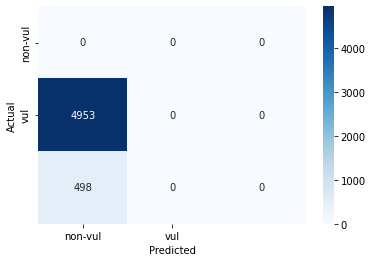

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, np.round(y_pred))
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='Blues', yticklabels=['non-vul', 'vul'],xticklabels=['non-vul', 'vul'])
plt.xlabel("Predicted")
plt.ylabel("Actual") 

In [ ]:
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.91      1.00      0.95      4953
         1.0       0.00      0.00      0.00       498

    accuracy                           0.91      5451
   macro avg       0.30      0.33      0.32      5451
weighted avg       0.83      0.91      0.87      5451



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

## Representation learning with class weight

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = len(y_train)
# y_train = y_train.argmax(axis=1)
# y_test = y_test.argmax(axis=1)
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}


print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.48


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling1D,Input,concatenate,Concatenate
from stellargraph.layer.gcn import GraphConvolution
import tensorflow_addons as tfa

# Model CNN cũ
# Sửa lại padding = same cho tất cả các Conv layer
# Thêm 1 block Conv
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(n_node_max,n_node_max, 1)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    
    return model

def create_gcn_model():
    x_features = Input(shape=( n_node_max, n_node_feature))
    x_adjacency = Input(shape=( n_node_max, n_node_max))
    out = Dropout(0.5)(x_features)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])
    out = Dropout(0.5)(out)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])

    # out = GlobalAveragePooling1D()(out)
    out = Flatten()(out)
    out = Dense(64, activation='relu')(out)
    out = Dropout(.25)(out)

    model = Model(inputs=[x_features, x_adjacency], outputs=out)

    return model

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]


In [ ]:
def create_model() : 
  model1 = create_cnn_model()
  model2 = create_gcn_model()

  
  out = Concatenate()([model1.output,model2.output])
  # out = Flatten()(out)    
  out = Dense(64, activation='relu')(out)
  out = Dropout(.5)(out)
  out = Dense(32, activation='relu')(out)
  out = Dense(n_class, activation='sigmoid')(out)

  model = Model([model1.input,model2.input], out)
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
  model.summary()
  return model

In [ ]:
model = create_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=30,
    mode='max',
    restore_best_weights=True)
model.fit(x = X_train, y = y_train, batch_size=256, epochs=100, callbacks=[early_stopping], class_weight=class_weight)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_18_input (InputLayer)   [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 112, 112, 32  320         ['conv2d_18_input[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 112, 112, 32  9248        ['conv2d_18[0][0]']              
                                )                                                           

In [ ]:
presentation_model = Model(inputs=model.inputs, outputs=model.layers[-5].output)
presentation_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_18_input (InputLayer)   [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 112, 112, 32  320         ['conv2d_18_input[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 112, 112, 32  9248        ['conv2d_18[0][0]']              
                                )                                                           

In [ ]:
X_test = presentation_model.predict(X_test)
print(X_test.shape)

(5451, 128)


In [ ]:
X_train = presentation_model.predict(X_train)

In [ ]:
# print(X_train.shape)
print(y_test.shape)

(5451,)


In [ ]:
from collections import Counter

print(Counter(y_train))

Counter({0: 11558, 1: 5779})


In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
print(Counter(y_train))

Counter({0: 11558, 1: 11558})


In [ ]:
def classifierModel():
    model = Sequential()
    model.add(Input(shape=(128)))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(n_class, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tfa.losses.TripletSemiHardLoss(), metrics=METRICS)
    model.summary()
    return model

In [ ]:
checkpoint_filepath = 'best.hdf5'
model = classifierModel()
# monitor="val_loss"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',save_best_only=True, verbose=1)
history = model.fit( x = X_train, y = y_train, batch_size=256, epochs=100, callbacks=[model_checkpoint_callback], validation_data = [X_test, y_test])

In [ ]:
checkpoint_filepath = 'best.hdf5'
model = classifierModel()
model.load_weights(checkpoint_filepath)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 64)                8256      
                                                                 
 dropout_72 (Dropout)        (None, 64)                0         
                                                                 
 dense_76 (Dense)            (None, 32)                2080      
                                                                 
 dropout_73 (Dropout)        (None, 32)                0         
                                                                 
 dense_77 (Dense)            (None, 8)                 264       
                                                                 
 dropout_74 (Dropout)        (None, 8)                 0         
                                                                 
 dense_78 (Dense)            (None, 1)               

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

171/171 [==============================] - 2s 5ms/step - loss: 0.8313 - tp: 343.0000 - fp: 1122.0000 - tn: 8784.0000 - fn: 653.0000 - accuracy: 0.8372 - precision: 0.2341 - recall: 0.3444 - auc: 0.6298 - prc: 0.1656
Test loss: 0.8312634825706482 / Test accuracy: 343.0


Text(33.0, 0.5, 'Actual')

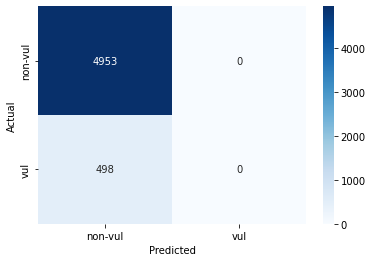

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='Blues', yticklabels=['non-vul', 'vul'],xticklabels=['non-vul', 'vul'])
plt.xlabel("Predicted")
plt.ylabel("Actual") 

In [ ]:
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      4953
           1       0.00      0.00      0.00       498

    accuracy                           0.91      5451
   macro avg       0.45      0.50      0.48      5451
weighted avg       0.83      0.91      0.87      5451



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Representation learning with oversampling train data

In [ ]:
# Oversampling
from imblearn.over_sampling import RandomOverSampler

over = RandomOverSampler(sampling_strategy=0.5)
import numpy as np
index = np.arange(0, len(y_train)).reshape(-1, 1)
x_index, y = over.fit_resample(index, y_train)

In [ ]:
index = x_index.reshape(1, -1)[0]
print(y_train[index].shape)

(17337,)


In [ ]:
X_train = [X_train[i][index] for i in range(0, 3)]
y_train = y_train[index]

In [ ]:
print("neg: ", (y_test == 0).sum())
print("pos: ", (y_test == 1).sum())

neg:  4953
pos:  498


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling1D,Input,concatenate,Concatenate
from stellargraph.layer.gcn import GraphConvolution
import tensorflow_addons as tfa

# Model CNN cũ
# Sửa lại padding = same cho tất cả các Conv layer
# Thêm 1 block Conv
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(n_node_max,n_node_max, 1)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (1, 1), padding='same', activation='relu'))
    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    
    return model

def create_gcn_model():
    x_features = Input(shape=( n_node_max, n_node_feature))
    x_adjacency = Input(shape=( n_node_max, n_node_max))
    out = Dropout(0.5)(x_features)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])
    out = Dropout(0.5)(out)
    out = GraphConvolution(32, activation='relu', 
                        use_bias=True
                        )([out, x_adjacency])

    # out = GlobalAveragePooling1D()(out)
    out = Flatten()(out)
    out = Dense(64, activation='relu')(out)
    out = Dropout(.25)(out)

    model = Model(inputs=[x_features, x_adjacency], outputs=out)

    return model

In [ ]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
  ]


In [ ]:
def create_model() : 
  model1 = create_cnn_model()
  model2 = create_gcn_model()

  
  out = Concatenate()([model1.output,model2.output])
  # out = Flatten()(out)    
  out = Dense(64, activation='relu')(out)
  out = Dropout(.5)(out)
  out = Dense(32, activation='relu')(out)
  out = Dense(n_class, activation='sigmoid')(out)

  model = Model([model1.input,model2.input], out)
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
  model.summary()
  return model

In [ ]:
model = create_model()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
model.fit(x = X_train, y = y_train, batch_size=256, epochs=100, validation_split=0.3)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_72_input (InputLayer)   [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 112, 112, 32  320         ['conv2d_72_input[0][0]']        
                                )                                                                 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 112, 112, 32  9248        ['conv2d_72[0][0]']              
                                )                                                          

KeyboardInterrupt: ignored

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, np.round(y_pred))
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='Blues', yticklabels=['non-vul', 'vul'],xticklabels=['non-vul', 'vul'])
plt.xlabel("Predicted")
plt.ylabel("Actual") 

In [ ]:
y_pred[y_pred>0.5].shape

(230,)

In [ ]:
presentation_model = Model(inputs=model.inputs, outputs=model.layers[-5].output)
presentation_model.summary()

In [ ]:
X_test = presentation_model.predict(X_test)
print(X_test.shape)

In [ ]:
X_train = presentation_model.predict(X_train)

In [ ]:
print(X_train.shape)
print(y_test.shape)

In [ ]:
from collections import Counter

print(Counter(y_train))

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE(sampling_strategy=0.5)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [ ]:
print(Counter(y_train))

In [ ]:
def classifierModel():
    model = Sequential()
    model.add(Input(shape=(128)))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(n_class, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS)
    model.summary()
    return model

In [ ]:
checkpoint_filepath = 'best.hdf5'
model = classifierModel()
# monitor="val_loss"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,monitor='val_accuracy',save_best_only=True, verbose=1)
history = model.fit( x = X_train, y = y_train, batch_size=256, epochs=100, callbacks=[model_checkpoint_callback], validation_data = [X_test, y_test])

In [ ]:
checkpoint_filepath = 'best.hdf5'
model = classifierModel()
model.load_weights(checkpoint_filepath)

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 64)                8256      
                                                                 
 dropout_126 (Dropout)       (None, 64)                0         
                                                                 
 dense_113 (Dense)           (None, 32)                2080      
                                                                 
 dropout_127 (Dropout)       (None, 32)                0         
                                                                 
 dense_114 (Dense)           (None, 8)                 264       
                                                                 
 dropout_128 (Dropout)       (None, 8)                 0         
                                                                 
 dense_115 (Dense)           (None, 1)               

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

matrix = confusion_matrix(y_test, np.round(y_pred))
sns.heatmap(matrix, annot=True, fmt='.0f', cmap='Blues', yticklabels=['non-vul', 'vul'],xticklabels=['non-vul', 'vul'])
plt.xlabel("Predicted")
plt.ylabel("Actual") 

In [ ]:
print(classification_report(y_test, np.round(y_pred)))